# X-Ray CNN Neural Network

### Authors: Blaise Swartwood, Brian Beasley, Tomasso Calviello

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import os
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [2]:
# Step 1: Set up data transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),  # ResNet expects 224x224 images
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalization for pre-trained models
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [3]:
# Step 2: Load the data
data_dir = './data/chest_xray'
image_datasets = {
    'train': datasets.ImageFolder(os.path.join(data_dir, 'train'), data_transforms['train']),
    'val': datasets.ImageFolder(os.path.join(data_dir, 'val'), data_transforms['val']),
    'test': datasets.ImageFolder(os.path.join(data_dir, 'test'), data_transforms['test'])
}

dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=32, shuffle=True),
    'val': DataLoader(image_datasets['val'], batch_size=32, shuffle=False),
    'test': DataLoader(image_datasets['test'], batch_size=32, shuffle=False)
}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

In [4]:
# Step 3: Set up the model (ResNet50)
#device = torch.device("cpu")  # Use CPU only
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use GPU if available

model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # Modify the final layer for binary classification (pneumonia vs normal)
model = model.to(device)

# Step 4: Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()  # For binary classification
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

/home/swartwba/.conda/envs/csse416/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/swartwba/.conda/envs/csse416/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
# Step 5: Training loop
def train_model(model, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluation mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward pass + optimize in training mode
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    print('Training complete')

# Step 6: Model testing and confusion matrix plotting
def test_model(model):
    model.eval()  # Set model to evaluation mode
    running_corrects = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():  # No need to compute gradients for testing
        for inputs, labels in dataloaders['test']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            running_corrects += torch.sum(preds == labels.data)

            all_preds.extend(preds.cpu().numpy())  # Store predictions
            all_labels.extend(labels.cpu().numpy())  # Store true labels

    test_acc = running_corrects.double() / dataset_sizes['test']
    print(f'Test Accuracy: {test_acc:.4f}')

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Pneumonia X-Ray Confusion Matrix")
    plt.show()

# Step 7: Save the model
def save_model(model, path='resnet50_pneumonia.pth'):
    torch.save(model.state_dict(), path)
    print(f"Model saved as {path}")

In [6]:
# Step 8: Start training the model
train_model(model, criterion, optimizer)

Epoch 1/10
----------
train Loss: 0.1618 Acc: 0.9346
val Loss: 0.1798 Acc: 0.9375
Epoch 2/10
----------
train Loss: 0.0557 Acc: 0.9801
val Loss: 0.2840 Acc: 0.8125
Epoch 3/10
----------
train Loss: 0.0369 Acc: 0.9866
val Loss: 0.1696 Acc: 0.8750
Epoch 4/10
----------
train Loss: 0.0206 Acc: 0.9942
val Loss: 0.0623 Acc: 1.0000
Epoch 5/10
----------
train Loss: 0.0163 Acc: 0.9944
val Loss: 0.2824 Acc: 0.8125
Epoch 6/10
----------
train Loss: 0.0107 Acc: 0.9965
val Loss: 0.0474 Acc: 1.0000
Epoch 7/10
----------
train Loss: 0.0061 Acc: 0.9985
val Loss: 0.0458 Acc: 1.0000
Epoch 8/10
----------
train Loss: 0.0038 Acc: 0.9992
val Loss: 0.0071 Acc: 1.0000
Epoch 9/10
----------
train Loss: 0.0055 Acc: 0.9987
val Loss: 0.0136 Acc: 1.0000
Epoch 10/10
----------
train Loss: 0.0037 Acc: 0.9994
val Loss: 0.0086 Acc: 1.0000
Training complete


Test Accuracy: 0.7965


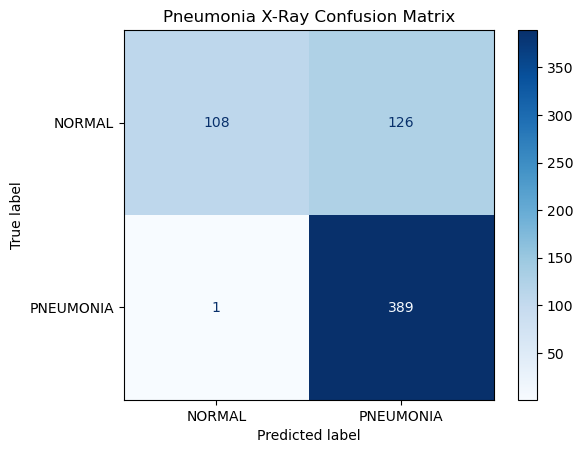

In [9]:
# Step 9: Test the model
test_model(model)

In [10]:
save_model(model)

Model saved as resnet50_pneumonia.pth
